In [5]:

# Data augmentation
augmentation = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [6]:
# removing the top layer of the base model
base_Model = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

# creating the head of the model
head_Model = base_Model.output
head_Model = AveragePooling2D(pool_size=(2, 2))(head_Model)
head_Model = Flatten(name="flatten")(head_Model)
head_Model = Dense(128, activation="relu")(head_Model)
head_Model = Dropout(0.5)(head_Model)
head_Model = Dense(2, activation="softmax")(head_Model)

In [7]:
# placing the head  model on top of the base model 
InceptionV3model = Model(inputs=base_Model.input, outputs=head_Model)

#looping over all layers to freeze the model
for layers in base_Model.layers:
    layers.trainable = False

# compiling the model
print("[INFO] compiling the model...")
optimize = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
InceptionV3model.compile(loss="binary_crossentropy", optimizer=optimize,
      metrics=["accuracy"])

[INFO] compiling the model...


D:\anaconda\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [8]:
 # trainning the model
print("[INFO] training the model...")
L = InceptionV3model.fit(
    augmentation.flow(trainX,trainY,batch_size=BS),
    steps_per_epoch=len(trainX)//BS,
    validation_data=(testX,testY),
    validation_steps=len(testX)//BS,
    epochs=EPOCHS)

[INFO] training the model...
Epoch 1/2
129/129 [==============================] - 453s 3s/step - loss: 0.1030 - accuracy: 0.9650 - val_loss: 0.0178 - val_accuracy: 0.9958
Epoch 2/2
129/129 [==============================] - 495s 4s/step - loss: 0.0373 - accuracy: 0.9889 - val_loss: 0.0129 - val_accuracy: 0.9958


In [9]:
print("[INFO] evaluating the model...")
predIdxs =InceptionV3model.predict(testX, batch_size=BS)

# for each and every image in the testing set, we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# printing the classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
     target_names=lb.classes_))

# saving the model
print("[INFO] saving mask detection model...")
InceptionV3model.save("mask_detection.model", save_format="h5")

[INFO] evaluating the model...
              precision    recall  f1-score   support

    withmask       1.00      0.99      1.00      1177
 withoutmask       0.99      1.00      1.00      1182

    accuracy                           1.00      2359
   macro avg       1.00      1.00      1.00      2359
weighted avg       1.00      1.00      1.00      2359

[INFO] saving mask detection model...


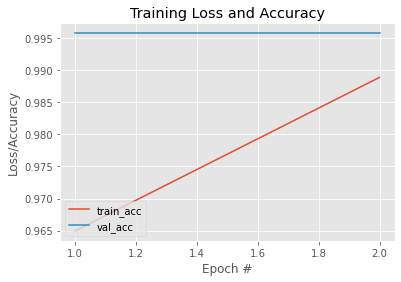

In [16]:
K= EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(1, K+1), L.history["accuracy"], label="train_acc")
plt.plot(np.arange(1, K+1), L.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

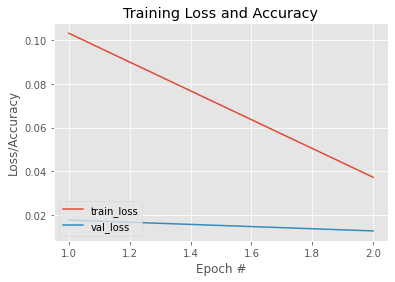

In [17]:
K= EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(1, K+1), L.history["loss"], label="train_loss")
plt.plot(np.arange(1, K+1), L.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")